In [2]:

import tensorflow as tf
import numpy as np
import random
import os

In [3]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [4]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [5]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [6]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [7]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_2HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '99.mat')
  X99_normal = scipy.io.loadmat(file_path1)['X099_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

    
  # X111_InnerRace_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/111.mat')['X111_DE_time']
  file_path2 = os.path.join(folder_path, '111.mat')
  X111_InnerRace_007  = scipy.io.loadmat(file_path2)['X111_DE_time']

  # X124_Ball_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/124.mat')['X124_DE_time']
  file_path3 = os.path.join(folder_path, '124.mat')
  X124_Ball_007 = scipy.io.loadmat(file_path3)['X124_DE_time']

  # X137_Outer_007 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/137.mat')['X137_DE_time']
  file_path4 = os.path.join(folder_path, '137.mat')
  X137_Outer_007 = scipy.io.loadmat(file_path4)['X137_DE_time']
    
  # X176_InnerRace_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/176.mat')['X176_DE_time']
  file_path5 = os.path.join(folder_path, '176.mat')
  X176_InnerRace_014 = scipy.io.loadmat(file_path5)['X176_DE_time']

  # X191_Ball_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/191.mat')['X191_DE_time']
  file_path6 = os.path.join(folder_path, '191.mat')
  X191_Ball_014 = scipy.io.loadmat(file_path6)['X191_DE_time']
    
  # X203_Outer_014 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/203.mat')['X203_DE_time']
  file_path7 = os.path.join(folder_path, '203.mat')
  X203_Outer_014  = scipy.io.loadmat(file_path7)['X203_DE_time']

  #  X215_InnerRace_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/215.mat')['X215_DE_time']
  file_path8 = os.path.join(folder_path, '215.mat')
  X215_InnerRace_021  = scipy.io.loadmat(file_path8)['X215_DE_time']
    
  # X228_Ball_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/228.mat')['X228_DE_time']
  file_path9 = os.path.join(folder_path, '228.mat')
  X228_Ball_021  = scipy.io.loadmat(file_path9)['X228_DE_time']

  # X240_Outer_021 = scipy.io.loadmat('/content/drive/MyDrive/BearingData_CaseWestern/240.mat')['X240_DE_time']
  file_path10 = os.path.join(folder_path, '240.mat')
  X240_Outer_021  = scipy.io.loadmat(file_path10)['X240_DE_time'] 
  
    
  return [X99_normal,X111_InnerRace_007,X124_Ball_007,X137_Outer_007,X176_InnerRace_014,X191_Ball_014,X203_Outer_014,X215_InnerRace_021,X228_Ball_021,X240_Outer_021]

In [8]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [9]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
    
interval_length = 1600 #320 #290 #200  
samples_per_block = 1600 #1296 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (485063, 1)
Dataset 2 shape: (485643, 1)
Dataset 3 shape: (486804, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (487964, 1)
Dataset 6 shape: (487384, 1)
Dataset 7 shape: (486804, 1)
Dataset 8 shape: (491446, 1)
Dataset 9 shape: (487384, 1)
Dataset 10 shape: (487964, 1)
[[ 0.06425354  0.06300185 -0.00438092 ...  0.01460308  0.06404492
   0.09804923]
 [ 0.08615815  0.06446215  0.06154154 ...  0.00917908  0.01585477
  -0.00792738]
 [-0.02712    -0.00104308  0.03004062 ...  0.062376    0.043392
   0.03316985]
 ...
 [-0.202824   -0.13438133 -0.06176533 ... -0.490784   -0.25958133
  -0.017528  ]
 [ 0.197816    0.34889067  0.39396267 ...  0.26959733  0.32218133
   0.27210133]
 [ 0.16276     0.020032   -0.08764    ... -0.39897067 -0.21117067
  -0.005008  ]]
Shape of Input Data = (3026, 1600)
Shape of Label Y_CNN = (3026, 10)
Shape of Label Y = (3026, 1)


In [10]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx


In [11]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,40,40,1])

# Input_2D = X_image.reshape([-1,40,40,1])
print(Input_2D.shape)


(3026, 40, 40, 1)


In [12]:
# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(40,40,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [13]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp1/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-05 17:14:16.580006: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2413 - loss: 2.0351
Epoch 1: val_accuracy improved from -inf to 0.65909, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2478 - loss: 2.0191 - val_accuracy: 0.6591 - val_loss: 0.9968
Epoch 2/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7110 - loss: 0.7769
Epoch 2: val_accuracy improved from 0.65909 to 0.73347, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7130 - loss: 0.7706 - val_accuracy: 0.7335 - val_loss: 0.6285
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7882 - loss: 0.5389
Epoch 3: val_accuracy improved from 0.73347 to 0.83471, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7886 - loss: 0.5377 - val_accuracy: 0.8347 - val_loss: 0.4411
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8159 - loss: 0.4432
Epoch 4: val_accuracy improved from 0.83471 to 0.86983, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8161 - loss: 0.4427 - val_accuracy: 0.8698 - val_loss: 0.3206
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8686 - loss: 0.3136
Epoch 5: val_accuracy did not improve from 0.86983
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8685 - loss: 0.3137 - val_accuracy: 0.8574 - val_loss: 0.3205
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8545 - loss: 0.3446
Epoch 6: val_accuracy improved from 0.86983 to 0.87190, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8546 - loss: 0.3444 - val_accuracy: 0.8719 - val_loss: 0.2878
Epoch 7/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8947 - loss: 0.2330
Epoch 7: val_accuracy improved from 0.87190 to 0.88636, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8946 - loss: 0.2333 - val_accuracy: 0.8864 - val_loss: 0.2421
Epoch 8/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9049 - loss: 0.2150
Epoch 8: val_accuracy did not improve from 0.88636
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9046 - loss: 0.2160 - val_accuracy: 0.8843 - val_loss: 0.2855
Epoch 9/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9171 - loss: 0.1962
Epoch 9: val_accuracy improved from 0.88636 to 0.89050, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9170 - loss: 0.1964 - val_accuracy: 0.8905 - val_loss: 0.2563
Epoch 10/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9207 - loss: 0.1885
Epoch 10: val_accuracy did not improve from 0.89050
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9202 - loss: 0.1898 - val_accuracy: 0.8678 - val_loss: 0.2952
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8821 - loss: 0.2600
Epoch 11: val_accuracy improved from 0.89050 to 0.89256, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8823 - loss: 0.2596 - val_accuracy: 0.8926 - val_loss: 0.2491
Epoch 12/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9259 - loss: 0.1658
Epoch 12: val_accuracy improved from 0.89256 to 0.91322, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9259 - loss: 0.1658 - val_accuracy: 0.9132 - val_loss: 0.2245
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9444 - loss: 0.1294
Epoch 13: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9444 - loss: 0.1294 - val_accuracy: 0.9112 - val_loss: 0.2141
Epoch 14/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9422 - loss: 0.1294
Epoch 14: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9424 - loss: 0.1292 - val_accuracy: 0.9091 - val_loss: 0.2304
Epoch 15/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9357 - loss: 0.1457
Epoch 15: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9348 - loss: 0.1482 - val_accuracy: 0.8471 - val_loss: 0.4286
Epoch 16/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8869 - loss: 0.3303
Epoch 16: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9461 - loss: 0.1390 - val_accuracy: 0.9463 - val_loss: 0.1771
Epoch 20/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9621 - loss: 0.0959
Epoch 20: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9624 - loss: 0.0957 - val_accuracy: 0.8926 - val_loss: 0.2712
Epoch 21/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9560 - loss: 0.1048
Epoch 21: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9561 - loss: 0.1044 - val_accuracy: 0.9029 - val_loss: 0.2675
Epoch 22/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9673 - loss: 0.0764
Epoch 22: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9676 - loss: 0.0760 - val_accuracy: 0.9298 - val_loss: 0.2127
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9768 - loss: 0.0574
Epoch 23: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9778 - loss: 0.0608 - val_accuracy: 0.9628 - val_loss: 0.1277
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9953 - loss: 0.0274
Epoch 30: val_accuracy did not improve from 0.96281
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9953 - loss: 0.0274 - val_accuracy: 0.9566 - val_loss: 0.1346
Epoch 31/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9929 - loss: 0.0227
Epoch 31: val_accuracy improved from 0.96281 to 0.96694, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9929 - loss: 0.0227 - val_accuracy: 0.9669 - val_loss: 0.1241
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9894 - loss: 0.0294
Epoch 32: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9895 - loss: 0.0295 - val_accuracy: 0.9566 - val_loss: 0.2094
Epoch 33/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9598 - loss: 0.1278
Epoch 33: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9601 - loss: 0.1268 - val_accuracy: 0.9628 - val_loss: 0.1040
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9950 - loss: 0.0192
Epoch 34: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9951 - loss: 0.0191 - val_accuracy: 0.9587 - val_loss: 0.1673
Epoch 35/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9955 - loss: 0.0158
Epoch 35: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9923 - loss: 0.0174 - val_accuracy: 0.9752 - val_loss: 0.0600
Epoch 38/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 38: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9731 - val_loss: 0.0696
Epoch 39/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9995 - loss: 0.0017
Epoch 39: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9731 - val_loss: 0.0720
Epoch 40/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 40: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9731 - val_loss: 0.0739
Epoch 41/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 41: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9773 - val_loss: 0.0620
Epoch 42/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 9.8476e-04
Epoch 42: val_accuracy did not improve from 0.97727
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 9.8904e-04 - val_accuracy: 0.9773 - val_loss: 0.0592
Epoch 43/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 8.2962e-04
Epoch 43: val_accuracy improved from 0.97727 to 0.97934, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 8.3141e-04 - val_accuracy: 0.9793 - val_loss: 0.0571
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 7.2624e-04
Epoch 44: val_accuracy improved from 0.97934 to 0.98140, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 7.2629e-04 - val_accuracy: 0.9814 - val_loss: 0.0633
Epoch 45/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 45: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9793 - val_loss: 0.0655
Epoch 46/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 46: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9793 - val_loss: 0.0638
Epoch 47/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 7.5464e-04
Epoch 47: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 7.4631e-04 - val_accuracy: 0.9773 - val_loss: 0.0694
Epoch 48/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 4.4506e-04
Epoch 48: val_ac

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 1.0000 - loss: 7.8660e-05 - val_accuracy: 0.9835 - val_loss: 0.0657
Epoch 59/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 7.3437e-05
Epoch 59: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 7.3367e-05 - val_accuracy: 0.9835 - val_loss: 0.0658
Epoch 60/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 6.8921e-05
Epoch 60: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 6.8750e-05 - val_accuracy: 0.9814 - val_loss: 0.0660
Epoch 61/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 6.4714e-05
Epoch 61: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 6.4563e-05 - val_accuracy: 0.9835 - val_loss: 0.0661
Epoch 62/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 6.0632e-05


Best model loaded successfully!
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

2025-06-05 17:18:22.687599: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:18:22.688354: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 6.4118e-05
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9883 - loss: 0.0474
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9862 - loss: 0.0385
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2034 - loss: 2.0242
Epoch 1: val_accuracy improved from -inf to 0.49793, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2057 - loss: 2.0196 - val_accuracy: 0.4979 - val_loss: 1.0697
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6613 - loss: 0.9016
Epoch 2: val_accuracy improved from 0.49793 to 0.79959, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6623 - loss: 0.8989 - val_accuracy: 0.7996 - val_loss: 0.4599
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7763 - loss: 0.5409
Epoch 3: val_accuracy improved from 0.79959 to 0.81818, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7765 - loss: 0.5406 - val_accuracy: 0.8182 - val_loss: 0.4160
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8176 - loss: 0.4269
Epoch 4: val_accuracy improved from 0.81818 to 0.84504, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8177 - loss: 0.4263 - val_accuracy: 0.8450 - val_loss: 0.3429
Epoch 5/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8478 - loss: 0.3592
Epoch 5: val_accuracy did not improve from 0.84504
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8474 - loss: 0.3597 - val_accuracy: 0.8388 - val_loss: 0.3748
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8479 - loss: 0.3119
Epoch 6: val_accuracy did not improve from 0.84504
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8480 - loss: 0.3117 - val_accuracy: 0.8430 - val_loss: 0.3328
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8538 - loss: 0.2749
Epoch 7: val_accuracy improved from 0.84504 to 0.84711, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8538 - loss: 0.2749 - val_accuracy: 0.8471 - val_loss: 0.3082
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8673 - loss: 0.2400
Epoch 8: val_accuracy did not improve from 0.84711
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8673 - loss: 0.2402 - val_accuracy: 0.8450 - val_loss: 0.3630
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8616 - loss: 0.2753
Epoch 9: val_accuracy improved from 0.84711 to 0.85331, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8616 - loss: 0.2753 - val_accuracy: 0.8533 - val_loss: 0.3143
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8682 - loss: 0.2796
Epoch 10: val_accuracy did not improve from 0.85331
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8679 - loss: 0.2799 - val_accuracy: 0.7707 - val_loss: 0.5125
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8600 - loss: 0.2739
Epoch 11: val_accuracy did not improve from 0.85331
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8602 - loss: 0.2736 - val_accuracy: 0.8326 - val_loss: 0.3590
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8779 - loss: 0.2275
Epoch 12: val_accuracy did not improve from 0.85331
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8780 - loss: 0.2275 - val_accuracy: 0.8079 - val_loss: 0.4471
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8707 - loss: 0.2534
Epoch 13: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8921 - loss: 0.2296 - val_accuracy: 0.8760 - val_loss: 0.2571
Epoch 17/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8998 - loss: 0.1924
Epoch 17: val_accuracy did not improve from 0.87603
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9000 - loss: 0.1922 - val_accuracy: 0.8678 - val_loss: 0.2972
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9063 - loss: 0.1778
Epoch 18: val_accuracy improved from 0.87603 to 0.88223, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9064 - loss: 0.1776 - val_accuracy: 0.8822 - val_loss: 0.2349
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9122 - loss: 0.1503
Epoch 19: val_accuracy did not improve from 0.88223
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9121 - loss: 0.1505 - val_accuracy: 0.8802 - val_loss: 0.2301
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9140 - loss: 0.1571
Epoch 20: val_accuracy improved from 0.88223 to 0.88636, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9140 - loss: 0.1573 - val_accuracy: 0.8864 - val_loss: 0.2350
Epoch 21/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9266 - loss: 0.1364
Epoch 21: val_accuracy improved from 0.88636 to 0.89669, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9267 - loss: 0.1363 - val_accuracy: 0.8967 - val_loss: 0.2547
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9339 - loss: 0.1336
Epoch 22: val_accuracy did not improve from 0.89669
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9338 - loss: 0.1336 - val_accuracy: 0.8864 - val_loss: 0.3109
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9404 - loss: 0.1269
Epoch 23: val_accuracy improved from 0.89669 to 0.90909, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9405 - loss: 0.1268 - val_accuracy: 0.9091 - val_loss: 0.2536
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9368 - loss: 0.1269
Epoch 24: val_accuracy did not improve from 0.90909
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9368 - loss: 0.1272 - val_accuracy: 0.7789 - val_loss: 0.6912
Epoch 25/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9274 - loss: 0.2452
Epoch 25: val_accuracy did not improve from 0.90909
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9279 - loss: 0.2430 - val_accuracy: 0.8988 - val_loss: 0.2527
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9452 - loss: 0.1434
Epoch 26: val_accuracy improved from 0.90909 to 0.94008, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9453 - loss: 0.1431 - val_accuracy: 0.9401 - val_loss: 0.1755
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9658 - loss: 0.0848
Epoch 27: val_accuracy did not improve from 0.94008
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9659 - loss: 0.0847 - val_accuracy: 0.9339 - val_loss: 0.1862
Epoch 28/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9775 - loss: 0.0538
Epoch 28: val_accuracy did not improve from 0.94008
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9776 - loss: 0.0536 - val_accuracy: 0.9236 - val_loss: 0.2355
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9842 - loss: 0.0419
Epoch 29: val_accuracy did not improve from 0.94008
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9843 - loss: 0.0418 - val_accuracy: 0.9318 - val_loss: 0.2143
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9549 - loss: 0.1292
Epoch 30: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9728 - loss: 0.0807 - val_accuracy: 0.9483 - val_loss: 0.1568
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9879 - loss: 0.0291
Epoch 34: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9879 - loss: 0.0290 - val_accuracy: 0.9339 - val_loss: 0.2124
Epoch 35/200
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9881 - loss: 0.0363
Epoch 35: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9883 - loss: 0.0357 - val_accuracy: 0.9483 - val_loss: 0.1786
Epoch 36/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9899 - loss: 0.0248
Epoch 36: val_accuracy improved from 0.94835 to 0.95248, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9900 - loss: 0.0245 - val_accuracy: 0.9525 - val_loss: 0.1472
Epoch 37/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9950 - loss: 0.0169
Epoch 37: val_accuracy improved from 0.95248 to 0.96074, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9951 - loss: 0.0168 - val_accuracy: 0.9607 - val_loss: 0.1762
Epoch 38/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9930 - loss: 0.0194
Epoch 38: val_accuracy did not improve from 0.96074
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9930 - loss: 0.0194 - val_accuracy: 0.9463 - val_loss: 0.2195
Epoch 39/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9889 - loss: 0.0336
Epoch 39: val_accuracy did not improve from 0.96074
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9888 - loss: 0.0337 - val_accuracy: 0.9421 - val_loss: 0.1832
Epoch 40/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9786 - loss: 0.0603
Epoch 40: val_accuracy did not improve from 0.96074
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9784 - loss: 0.0607 - val_accuracy: 0.9504 - val_loss: 0.1976
Epoch 41/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9881 - loss: 0.0496
Epoch 41: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9988 - loss: 0.0058 - val_accuracy: 0.9628 - val_loss: 0.1576
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9941 - loss: 0.0212
Epoch 47: val_accuracy did not improve from 0.96281
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9939 - loss: 0.0216 - val_accuracy: 0.9091 - val_loss: 0.3026
Epoch 48/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9598 - loss: 0.1313
Epoch 48: val_accuracy did not improve from 0.96281
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9601 - loss: 0.1306 - val_accuracy: 0.9587 - val_loss: 0.1375
Epoch 49/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9891 - loss: 0.0270
Epoch 49: val_accuracy did not improve from 0.96281
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9893 - loss: 0.0267 - val_accuracy: 0.9628 - val_loss: 0.1111
Epoch 50/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9955 - loss: 0.0111
Epoch 50: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.9649 - val_loss: 0.1106
Epoch 54/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 5.3901e-04
Epoch 54: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 5.3947e-04 - val_accuracy: 0.9607 - val_loss: 0.1164
Epoch 55/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 4.2667e-04
Epoch 55: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 4.2660e-04 - val_accuracy: 0.9649 - val_loss: 0.1164
Epoch 56/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 3.9868e-04
Epoch 56: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 3.9883e-04 - val_accuracy: 0.9628 - val_loss: 0.1188
Epoch 57/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 3.0694e-04
Epoc

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 1.0000 - loss: 2.5139e-04 - val_accuracy: 0.9669 - val_loss: 0.1218
Epoch 59/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 2.0580e-04
Epoch 59: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 2.0578e-04 - val_accuracy: 0.9669 - val_loss: 0.1227
Epoch 60/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.7513e-04
Epoch 60: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 1.7504e-04 - val_accuracy: 0.9669 - val_loss: 0.1238
Epoch 61/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.5439e-04
Epoch 61: val_accuracy improved from 0.96694 to 0.96901, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 1.0000 - loss: 1.5428e-04 - val_accuracy: 0.9690 - val_loss: 0.1251
Epoch 62/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.3878e-04
Epoch 62: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 1.3866e-04 - val_accuracy: 0.9690 - val_loss: 0.1263
Epoch 63/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.2619e-04
Epoch 63: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 1.2607e-04 - val_accuracy: 0.9690 - val_loss: 0.1274
Epoch 64/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 1.1577e-04
Epoch 64: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 1.1554e-04 - val_accuracy: 0.9690 - val_loss: 0.1286
Epoch 65/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 1.0651e-04


Best model saved at: CNN2D_results/V4_2_NOL_exp1/best_model_2.h5
Best model loaded successfully!
 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

2025-06-05 17:22:39.806839: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:22:39.807182: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.3333e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9772 - loss: 0.0891
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9704 - loss: 0.1373
Epoch 1/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1931 - loss: 2.0669

2025-06-05 17:22:45.675564: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:22:45.675844: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.53926, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1973 - loss: 2.0594 - val_accuracy: 0.5393 - val_loss: 1.1849
Epoch 2/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6401 - loss: 0.9433
Epoch 2: val_accuracy improved from 0.53926 to 0.71901, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6419 - loss: 0.9391 - val_accuracy: 0.7190 - val_loss: 0.7583
Epoch 3/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7854 - loss: 0.5750
Epoch 3: val_accuracy improved from 0.71901 to 0.81818, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7858 - loss: 0.5735 - val_accuracy: 0.8182 - val_loss: 0.4228
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8451 - loss: 0.3701
Epoch 4: val_accuracy improved from 0.81818 to 0.83264, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8450 - loss: 0.3703 - val_accuracy: 0.8326 - val_loss: 0.4168
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8404 - loss: 0.3617
Epoch 5: val_accuracy did not improve from 0.83264
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8403 - loss: 0.3618 - val_accuracy: 0.8306 - val_loss: 0.3943
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8654 - loss: 0.3111
Epoch 6: val_accuracy improved from 0.83264 to 0.87190, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8654 - loss: 0.3113 - val_accuracy: 0.8719 - val_loss: 0.3022
Epoch 7/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8837 - loss: 0.2806
Epoch 7: val_accuracy improved from 0.87190 to 0.88843, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8836 - loss: 0.2810 - val_accuracy: 0.8884 - val_loss: 0.2767
Epoch 8/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8979 - loss: 0.2404
Epoch 8: val_accuracy improved from 0.88843 to 0.89463, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8978 - loss: 0.2405 - val_accuracy: 0.8946 - val_loss: 0.2921
Epoch 9/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8899 - loss: 0.2758
Epoch 9: val_accuracy improved from 0.89463 to 0.90289, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8904 - loss: 0.2748 - val_accuracy: 0.9029 - val_loss: 0.2530
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9045 - loss: 0.2148
Epoch 10: val_accuracy did not improve from 0.90289
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9047 - loss: 0.2145 - val_accuracy: 0.9029 - val_loss: 0.2411
Epoch 11/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9084 - loss: 0.2009
Epoch 11: val_accuracy did not improve from 0.90289
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9085 - loss: 0.2008 - val_accuracy: 0.8946 - val_loss: 0.2564
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9136 - loss: 0.1900
Epoch 12: val_accuracy improved from 0.90289 to 0.90496, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9139 - loss: 0.1897 - val_accuracy: 0.9050 - val_loss: 0.2208
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9261 - loss: 0.1802
Epoch 13: val_accuracy did not improve from 0.90496
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9260 - loss: 0.1808 - val_accuracy: 0.8533 - val_loss: 0.4707
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9166 - loss: 0.2004
Epoch 14: val_accuracy improved from 0.90496 to 0.90702, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9168 - loss: 0.2000 - val_accuracy: 0.9070 - val_loss: 0.2653
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9503 - loss: 0.1361
Epoch 15: val_accuracy improved from 0.90702 to 0.93388, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9503 - loss: 0.1359 - val_accuracy: 0.9339 - val_loss: 0.1616
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9562 - loss: 0.1133
Epoch 16: val_accuracy improved from 0.93388 to 0.93802, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9562 - loss: 0.1131 - val_accuracy: 0.9380 - val_loss: 0.1514
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9635 - loss: 0.0987
Epoch 17: val_accuracy did not improve from 0.93802
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9635 - loss: 0.0986 - val_accuracy: 0.9380 - val_loss: 0.1577
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9629 - loss: 0.0965
Epoch 18: val_accuracy improved from 0.93802 to 0.94835, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9629 - loss: 0.0964 - val_accuracy: 0.9483 - val_loss: 0.1517
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9715 - loss: 0.0788
Epoch 19: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9714 - loss: 0.0789 - val_accuracy: 0.9174 - val_loss: 0.2396
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9671 - loss: 0.0916
Epoch 20: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9671 - loss: 0.0914 - val_accuracy: 0.9277 - val_loss: 0.1889
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9431 - loss: 0.1572
Epoch 21: val_accuracy did not improve from 0.94835
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9431 - loss: 0.1573 - val_accuracy: 0.9360 - val_loss: 0.1676
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9417 - loss: 0.1615
Epoch 22: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9417 - loss: 0.1613 - val_accuracy: 0.9525 - val_loss: 0.1126
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9740 - loss: 0.0697
Epoch 23: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9740 - loss: 0.0697 - val_accuracy: 0.9504 - val_loss: 0.1144
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9774 - loss: 0.0625
Epoch 24: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9775 - loss: 0.0623 - val_accuracy: 0.9525 - val_loss: 0.1203
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9838 - loss: 0.0526
Epoch 25: val_accuracy improved from 0.95248 to 0.96488, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9839 - loss: 0.0523 - val_accuracy: 0.9649 - val_loss: 0.1000
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9959 - loss: 0.0260
Epoch 26: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9959 - loss: 0.0259 - val_accuracy: 0.9607 - val_loss: 0.1394
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9912 - loss: 0.0282
Epoch 27: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9913 - loss: 0.0281 - val_accuracy: 0.9545 - val_loss: 0.1491
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9948 - loss: 0.0259
Epoch 28: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9948 - loss: 0.0258 - val_accuracy: 0.9628 - val_loss: 0.1409
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9990 - loss: 0.0140
Epoch 29: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9875 - loss: 0.0382 - val_accuracy: 0.9752 - val_loss: 0.0714
Epoch 32/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9971 - loss: 0.0137
Epoch 32: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9972 - loss: 0.0137 - val_accuracy: 0.9752 - val_loss: 0.0775
Epoch 33/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9971 - loss: 0.0114
Epoch 33: val_accuracy improved from 0.97521 to 0.97727, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9972 - loss: 0.0113 - val_accuracy: 0.9773 - val_loss: 0.0857
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9990 - loss: 0.0086
Epoch 34: val_accuracy did not improve from 0.97727
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9991 - loss: 0.0086 - val_accuracy: 0.9731 - val_loss: 0.0812
Epoch 35/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9990 - loss: 0.0064
Epoch 35: val_accuracy improved from 0.97727 to 0.97934, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9991 - loss: 0.0063 - val_accuracy: 0.9793 - val_loss: 0.0782
Epoch 36/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9990 - loss: 0.0046
Epoch 36: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9711 - val_loss: 0.0826
Epoch 37/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9990 - loss: 0.0040
Epoch 37: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9731 - val_loss: 0.0798
Epoch 38/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9990 - loss: 0.0036
Epoch 38: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9731 - val_loss: 0.0786
Epoch 39/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9990 - loss: 0.0027
Epoch 39: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9991 - loss: 0.0022 - val_accuracy: 0.9814 - val_loss: 0.0777
Epoch 41/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9990 - loss: 0.0018
Epoch 41: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9991 - loss: 0.0018 - val_accuracy: 0.9814 - val_loss: 0.0775
Epoch 42/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9990 - loss: 0.0014
Epoch 42: val_accuracy improved from 0.98140 to 0.98347, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9991 - loss: 0.0014 - val_accuracy: 0.9835 - val_loss: 0.0775
Epoch 43/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 43: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9835 - val_loss: 0.0777
Epoch 44/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 7.4830e-04
Epoch 44: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 1.0000 - loss: 7.4212e-04 - val_accuracy: 0.9814 - val_loss: 0.0786
Epoch 45/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 6.0795e-04
Epoch 45: val_accuracy did not improve from 0.98347
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 6.0321e-04 - val_accuracy: 0.9814 - val_loss: 0.0793
Epoch 46/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 5.6450e-04
Epoch 46: va

Best model saved at: CNN2D_results/V4_2_NOL_exp1/best_model_3.h5
Best model loaded successfully!
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

2025-06-05 17:26:45.828244: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:26:45.829236: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 4.5019e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9813 - loss: 0.0899
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0523
Epoch 1/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1849 - loss: 2.0315

2025-06-05 17:26:51.356066: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:26:51.356409: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.51653, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1884 - loss: 2.0245 - val_accuracy: 0.5165 - val_loss: 1.3693
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6132 - loss: 1.0786
Epoch 2: val_accuracy improved from 0.51653 to 0.78512, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6140 - loss: 1.0758 - val_accuracy: 0.7851 - val_loss: 0.5458
Epoch 3/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8021 - loss: 0.5270
Epoch 3: val_accuracy improved from 0.78512 to 0.80165, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8020 - loss: 0.5265 - val_accuracy: 0.8017 - val_loss: 0.4693
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8303 - loss: 0.4147
Epoch 4: val_accuracy improved from 0.80165 to 0.84504, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8304 - loss: 0.4143 - val_accuracy: 0.8450 - val_loss: 0.3622
Epoch 5/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8675 - loss: 0.3109
Epoch 5: val_accuracy improved from 0.84504 to 0.84917, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8673 - loss: 0.3108 - val_accuracy: 0.8492 - val_loss: 0.3423
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8779 - loss: 0.2734
Epoch 6: val_accuracy improved from 0.84917 to 0.86777, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8780 - loss: 0.2734 - val_accuracy: 0.8678 - val_loss: 0.3277
Epoch 7/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9052 - loss: 0.2274
Epoch 7: val_accuracy improved from 0.86777 to 0.86983, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9049 - loss: 0.2277 - val_accuracy: 0.8698 - val_loss: 0.3119
Epoch 8/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9058 - loss: 0.2313
Epoch 8: val_accuracy did not improve from 0.86983
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9057 - loss: 0.2313 - val_accuracy: 0.8595 - val_loss: 0.3605
Epoch 9/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9103 - loss: 0.2169
Epoch 9: val_accuracy improved from 0.86983 to 0.88223, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9101 - loss: 0.2168 - val_accuracy: 0.8822 - val_loss: 0.3254
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.2019
Epoch 10: val_accuracy improved from 0.88223 to 0.90702, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9235 - loss: 0.2020 - val_accuracy: 0.9070 - val_loss: 0.2675
Epoch 11/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9275 - loss: 0.1939
Epoch 11: val_accuracy did not improve from 0.90702
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9269 - loss: 0.1950 - val_accuracy: 0.8657 - val_loss: 0.2984
Epoch 12/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9050 - loss: 0.2516
Epoch 12: val_accuracy improved from 0.90702 to 0.91736, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9054 - loss: 0.2505 - val_accuracy: 0.9174 - val_loss: 0.2451
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9534 - loss: 0.1282
Epoch 13: val_accuracy did not improve from 0.91736
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9534 - loss: 0.1283 - val_accuracy: 0.8926 - val_loss: 0.3120
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9380 - loss: 0.1428
Epoch 14: val_accuracy did not improve from 0.91736
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9382 - loss: 0.1426 - val_accuracy: 0.8079 - val_loss: 0.6449
Epoch 15/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9263 - loss: 0.1849
Epoch 15: val_accuracy did not improve from 0.91736
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9261 - loss: 0.1852 - val_accuracy: 0.8512 - val_loss: 0.4491
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9155 - loss: 0.1743
Epoch 16: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9158 - loss: 0.1740 - val_accuracy: 0.9318 - val_loss: 0.2048
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9621 - loss: 0.0919
Epoch 17: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9620 - loss: 0.0920 - val_accuracy: 0.9112 - val_loss: 0.2264
Epoch 18/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9723 - loss: 0.0783
Epoch 18: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9722 - loss: 0.0783 - val_accuracy: 0.8926 - val_loss: 0.2680
Epoch 19/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9648 - loss: 0.0835
Epoch 19: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9649 - loss: 0.0832 - val_accuracy: 0.9174 - val_loss: 0.2173
Epoch 20/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9756 - loss: 0.0638
Epoch 20: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9755 - loss: 0.0640 - val_accuracy: 0.9401 - val_loss: 0.1515
Epoch 21/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9843 - loss: 0.0604
Epoch 21: val_accuracy improved from 0.94008 to 0.95455, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9841 - loss: 0.0609 - val_accuracy: 0.9545 - val_loss: 0.1423
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9786 - loss: 0.0657
Epoch 22: val_accuracy did not improve from 0.95455
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9785 - loss: 0.0659 - val_accuracy: 0.9421 - val_loss: 0.1919
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9776 - loss: 0.0636
Epoch 23: val_accuracy improved from 0.95455 to 0.96901, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9777 - loss: 0.0636 - val_accuracy: 0.9690 - val_loss: 0.1160
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9904 - loss: 0.0363
Epoch 24: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9903 - loss: 0.0364 - val_accuracy: 0.9628 - val_loss: 0.1304
Epoch 25/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9885 - loss: 0.0425
Epoch 25: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9884 - loss: 0.0425 - val_accuracy: 0.9587 - val_loss: 0.1285
Epoch 26/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9768 - loss: 0.0812
Epoch 26: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9767 - loss: 0.0814 - val_accuracy: 0.9463 - val_loss: 0.1572
Epoch 27/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9840 - loss: 0.0417
Epoch 27: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9727 - loss: 0.1028 - val_accuracy: 0.9793 - val_loss: 0.0605
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9940 - loss: 0.0246
Epoch 32: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9940 - loss: 0.0247 - val_accuracy: 0.9566 - val_loss: 0.1399
Epoch 33/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9897 - loss: 0.0269
Epoch 33: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9896 - loss: 0.0270 - val_accuracy: 0.9483 - val_loss: 0.1444
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9885 - loss: 0.0290
Epoch 34: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9886 - loss: 0.0289 - val_accuracy: 0.9752 - val_loss: 0.1125
Epoch 35/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9960 - loss: 0.0155
Epoch 35: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 1.0000 - loss: 2.3052e-04 - val_accuracy: 0.9814 - val_loss: 0.0822
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.8974e-04
Epoch 47: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 1.0000 - loss: 1.8989e-04 - val_accuracy: 0.9814 - val_loss: 0.0828
Epoch 48/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 1.7805e-04
Epoch 48: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 1.0000 - loss: 1.7810e-04 - val_accuracy: 0.9814 - val_loss: 0.0828
Epoch 49/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 1.6425e-04
Epoch 49: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 1.0000 - loss: 1.6423e-04 - val_accuracy: 0.9814 - val_loss: 0.0830
Epoch 50/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 1.4599e-04


Best model loaded successfully!
11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2025-06-05 17:31:39.468844: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:31:39.470085: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.5061e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9830 - loss: 0.0614
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9771 - loss: 0.0815
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2263 - loss: 1.9991

2025-06-05 17:31:45.390508: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-05 17:31:45.390832: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.53306, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2281 - loss: 1.9950 - val_accuracy: 0.5331 - val_loss: 1.1543
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6228 - loss: 1.0035
Epoch 2: val_accuracy improved from 0.53306 to 0.77893, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6235 - loss: 1.0012 - val_accuracy: 0.7789 - val_loss: 0.5950
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7636 - loss: 0.6113
Epoch 3: val_accuracy improved from 0.77893 to 0.78719, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7640 - loss: 0.6100 - val_accuracy: 0.7872 - val_loss: 0.5568
Epoch 4/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8127 - loss: 0.4936
Epoch 4: val_accuracy did not improve from 0.78719
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8133 - loss: 0.4914 - val_accuracy: 0.6508 - val_loss: 1.0146
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7992 - loss: 0.5368
Epoch 5: val_accuracy improved from 0.78719 to 0.80785, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7998 - loss: 0.5346 - val_accuracy: 0.8079 - val_loss: 0.4123
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8529 - loss: 0.3365
Epoch 6: val_accuracy improved from 0.80785 to 0.84091, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8532 - loss: 0.3358 - val_accuracy: 0.8409 - val_loss: 0.3558
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8569 - loss: 0.3281
Epoch 7: val_accuracy improved from 0.84091 to 0.88017, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8571 - loss: 0.3276 - val_accuracy: 0.8802 - val_loss: 0.2927
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8474 - loss: 0.3619
Epoch 8: val_accuracy did not improve from 0.88017
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8474 - loss: 0.3614 - val_accuracy: 0.8760 - val_loss: 0.2845
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8752 - loss: 0.2800
Epoch 9: val_accuracy improved from 0.88017 to 0.91116, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8753 - loss: 0.2796 - val_accuracy: 0.9112 - val_loss: 0.2316
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9118 - loss: 0.2109
Epoch 10: val_accuracy improved from 0.91116 to 0.91322, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9116 - loss: 0.2108 - val_accuracy: 0.9132 - val_loss: 0.2250
Epoch 11/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9201 - loss: 0.2011
Epoch 11: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9200 - loss: 0.2009 - val_accuracy: 0.9008 - val_loss: 0.2316
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9214 - loss: 0.1721
Epoch 12: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9214 - loss: 0.1721 - val_accuracy: 0.8781 - val_loss: 0.2874
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9104 - loss: 0.2090
Epoch 13: val_accuracy did not improve from 0.91322
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9100 - loss: 0.2106 - val_accuracy: 0.7376 - val_loss: 0.6849
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8524 - loss: 0.3943
Epoch 14: val_accuracy did not i

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9183 - loss: 0.1925 - val_accuracy: 0.9174 - val_loss: 0.1967
Epoch 16/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9315 - loss: 0.1622
Epoch 16: val_accuracy improved from 0.91736 to 0.92562, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9318 - loss: 0.1616 - val_accuracy: 0.9256 - val_loss: 0.1754
Epoch 17/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9495 - loss: 0.1220
Epoch 17: val_accuracy improved from 0.92562 to 0.93388, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9497 - loss: 0.1216 - val_accuracy: 0.9339 - val_loss: 0.1706
Epoch 18/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9580 - loss: 0.1030
Epoch 18: val_accuracy improved from 0.93388 to 0.96074, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9581 - loss: 0.1027 - val_accuracy: 0.9607 - val_loss: 0.1004
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9643 - loss: 0.0806
Epoch 19: val_accuracy improved from 0.96074 to 0.97521, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9644 - loss: 0.0805 - val_accuracy: 0.9752 - val_loss: 0.0853
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9669 - loss: 0.0878
Epoch 20: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9669 - loss: 0.0880 - val_accuracy: 0.9070 - val_loss: 0.2250
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9206 - loss: 0.1994
Epoch 21: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9207 - loss: 0.1994 - val_accuracy: 0.9628 - val_loss: 0.1956
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9530 - loss: 0.1692
Epoch 22: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9531 - loss: 0.1686 - val_accuracy: 0.9628 - val_loss: 0.1075
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9773 - loss: 0.0686
Epoch 23: val_accuracy improved 

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9774 - loss: 0.0684 - val_accuracy: 0.9773 - val_loss: 0.0808
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9887 - loss: 0.0411
Epoch 24: val_accuracy improved from 0.97727 to 0.98140, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9886 - loss: 0.0410 - val_accuracy: 0.9814 - val_loss: 0.0528
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9925 - loss: 0.0294
Epoch 25: val_accuracy improved from 0.98140 to 0.98967, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9926 - loss: 0.0294 - val_accuracy: 0.9897 - val_loss: 0.0500
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9904 - loss: 0.0276
Epoch 26: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9904 - loss: 0.0275 - val_accuracy: 0.9876 - val_loss: 0.0376
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9913 - loss: 0.0266
Epoch 27: val_accuracy improved from 0.98967 to 0.99380, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9912 - loss: 0.0268 - val_accuracy: 0.9938 - val_loss: 0.0404
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9696 - loss: 0.0830
Epoch 28: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9698 - loss: 0.0826 - val_accuracy: 0.9917 - val_loss: 0.0362
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9939 - loss: 0.0220
Epoch 29: val_accuracy improved from 0.99380 to 0.99587, saving model to CNN2D_results/V4_2_NOL_exp1/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9940 - loss: 0.0220 - val_accuracy: 0.9959 - val_loss: 0.0393
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9938 - loss: 0.0199
Epoch 30: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9752 - val_loss: 0.0617
Epoch 31/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9954 - loss: 0.0168
Epoch 31: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9953 - loss: 0.0168 - val_accuracy: 0.9793 - val_loss: 0.0554
Epoch 32/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9933 - loss: 0.0204
Epoch 32: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9932 - loss: 0.0205 - val_accuracy: 0.9525 - val_loss: 0.1118
Epoch 33/200
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9837 - loss: 0.0393
Epoch 33: val_accuracy did not i

Best model saved at: CNN2D_results/V4_2_NOL_exp1/best_model_5.h5
Best model loaded successfully!
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step

2025-06-05 17:35:05.027437: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:35:05.028356: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9993 - loss: 0.0067
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9975 - loss: 0.0301
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9645 - loss: 0.0584


CNN 2D train accuracy = 99.96900796890259
CNN 2D validation accuracy = 98.26446413993835
CNN 2D test accuracy = 97.35973715782166
11/76 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

2025-06-05 17:39:08.452241: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:39:08.452678: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


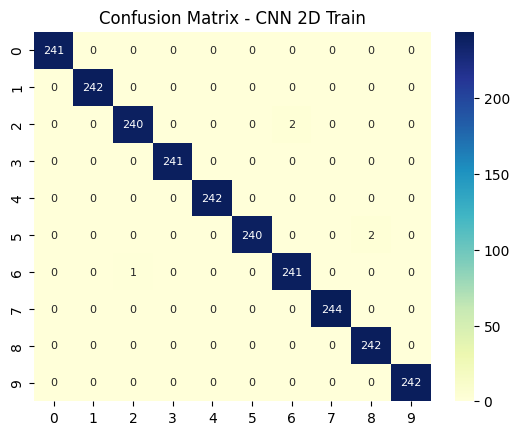

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


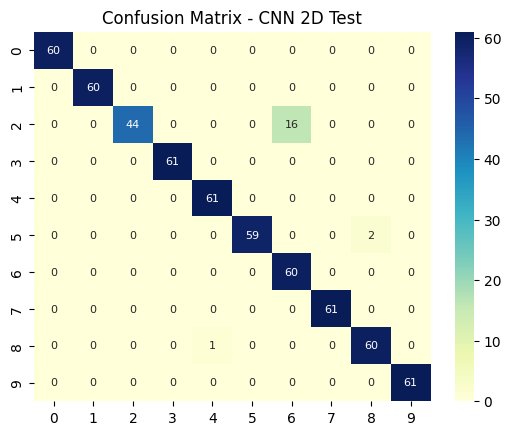

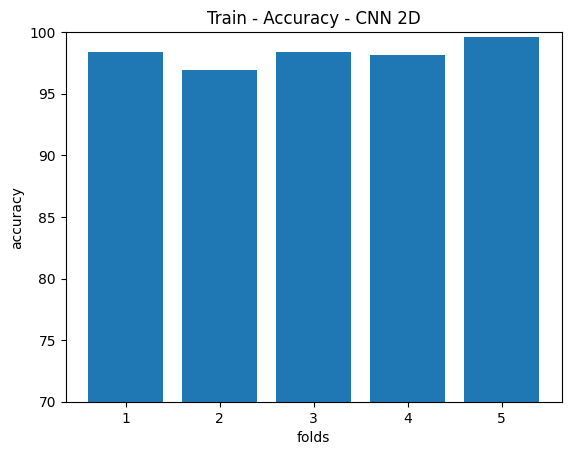

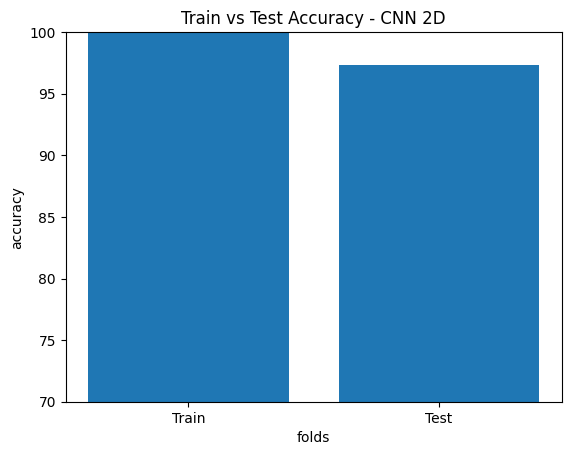

In [17]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()

In [15]:
from tensorflow.keras.models import load_model

# for i in range(1, 6):
#     filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_{i}.h5"
#     print(f"\nModel summary for fold {i}:")
#     model = load_model(filepath)
#     model.summary()
#     for i, layer in enumerate(model.layers):
#         print(f"{i}: {layer.name} — {layer.output_shape}")


filepath = f"CNN2D_results/V4_2_NOL_exp1/best_model_1.h5"
print(f"\nModel summary for fold 1:")
model = load_model(filepath)
model.summary()
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")
    
model.predict(X_2D_test)
layer_name = 'conv2d_20'  
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)






Model summary for fold 1:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 40, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,014 (851.62 KB)

 Trainable params: 218,012 (851.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

0: conv2d
1: max_pooling2d
2: conv2d_1
3: max_pooling2d_1
4: conv2d_2
5: max_pooling2d_2
6: conv2d_3
7: max_pooling2d_3
8: flatten
9: dense
10: dense_1
11: dense_2
12: softmax
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2025-06-05 17:35:10.640211: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-05 17:35:10.640524: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


AttributeError: The layer sequential has never been called and thus has no defined input.